## Portugese CD Marketing

Certificates of deposits (CD), where bank customers agree to leave their money for an extended period of time generally in return for a higher rate, are an important source of bank funds to support lending. In this notebook we will examine a bank's efforts at telemarketing to encourage new CD purchases.

Researchers "analyzed a recent and large dataset (52,944 records) from a Portuguese bank. The data were collected from 2008 to 2013, thus including the effects of the global financial crisis that peaked in 2008."

>Moro, S., Cortez, P. and Rita, P. 2014. "A data-driven approach to predict the success of bank telemarketing," _Decision Support Systems_ (62), pp. 22-31,

We will create a neural net model to use in predicting the response to a telemarketing call.

### <font color='firebrick'>Notebook Prep</font>

In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
#-------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing  
#-------------------
import pandas as pd

In [2]:
# define contstant variables
TEST_SIZE = 0.3 # can be percent or count
EPOCHS = 20
CALL_THRESHOLD = 0.95 # Only call prospective clients for CDs if model predicts over this rate
pd.set_option('display.max_rows', None)

### <font color='firebrick'>Preparing the Data</font>

#### Retrieve and Review the Data

In [3]:
# read the data
portugese_term_deposits_df = pd.read_csv('portugese_term_deposits.csv', sep=';') 

1. Let's make sure the data was read into the data frame correctly. Sometimes _odd" things happen, such as the data including an invisible return character which might result in incorrect column entries.

In [4]:
# check the data
portugese_term_deposits_df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


2. It is also good to know the size of the data set. It might be so large that to start, you take a subset of the data to avoiding waiting a long time for return results as you build the notebook. 

In [5]:
portugese_term_deposits_df.shape

(45211, 17)

3. Next we can 'glance' at the values for each feature and for the label. 

We can see which of the features will need to be converted to numbers or which features to eliminate (e.g., if an ID was included - logically it should have no relationship with the outcome). 

**Could any numeric column need to be converted into... numbers?** That is, are any of the numbers in the data really categories? Perhaps day or campaign? We will treat them as numbers for convenience.

Note that the data provided does not quite match to that of the UCI description - not an unusual occurence (in this case, the explanation is that this is one of a few data sets available for use).

Note that our target aka `y` is a string containing either "yes" or "no" and will also need to be converted to a number. 

In [6]:
# take a look at the columns value
portugese_term_deposits_df.apply(lambda col: col.unique())

age          [58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 5...
job          [management, technician, entrepreneur, blue-co...
marital                            [married, single, divorced]
education              [tertiary, secondary, unknown, primary]
default                                              [no, yes]
balance      [2143, 29, 2, 1506, 1, 231, 447, 121, 593, 270...
housing                                              [yes, no]
loan                                                 [no, yes]
contact                         [unknown, cellular, telephone]
day          [5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 21...
month        [may, jun, jul, aug, oct, nov, dec, jan, feb, ...
duration     [261, 151, 76, 92, 198, 139, 217, 380, 50, 55,...
campaign     [1, 2, 3, 5, 4, 6, 7, 8, 9, 10, 11, 12, 13, 19...
pdays        [-1, 151, 166, 91, 86, 143, 147, 89, 140, 176,...
previous     [0, 3, 1, 4, 2, 11, 16, 6, 5, 10, 12, 7, 18, 9...
poutcome                    [unknown, failure, other, s

4. Best practice would include looking at the data visually, looking at central tendencies and spread for numeric values and distribution across categories for object data types.

<Axes: >

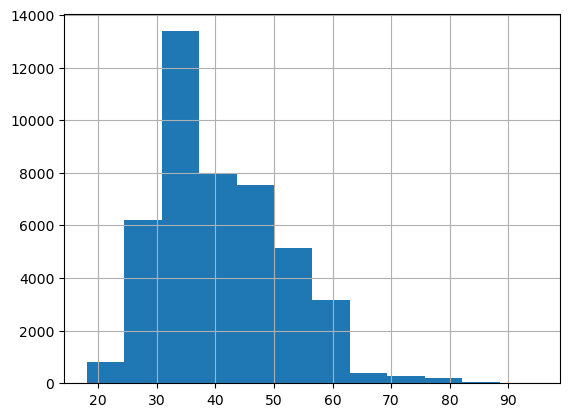

In [7]:
# histogram for age
portugese_term_deposits_df['age'].hist(bins=12)

<Axes: xlabel='Jobs', ylabel='Count'>

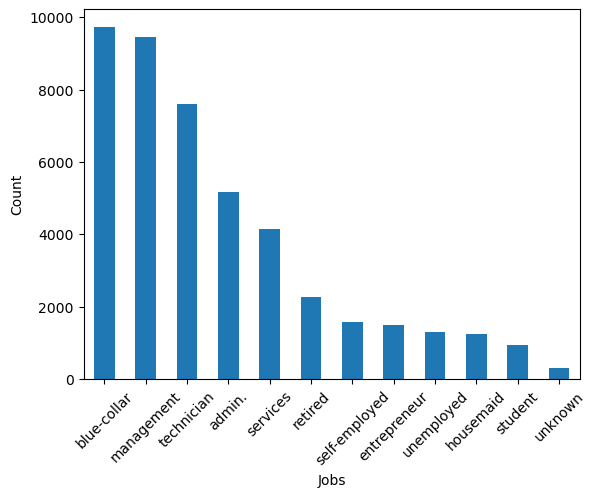

In [8]:
# bar chart for jobs count
portugese_term_deposits_df['job'].value_counts().plot(kind='bar', xlabel='Jobs', ylabel='Count', rot=45)

5. We need to check for missing values and display the data types to know what data preprocessing steps we need to take before fitting the model with the provided data. Note that `isna()` and `isnull()` return the same values.

In [9]:
# checking nulls
portugese_term_deposits_df.isnull().sum().sum()

0

In [10]:
print(portugese_term_deposits_df.dtypes)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


#### Process the Data

6. Before 'fixing' the data, we split the data into features (X) and labeles / targets (y) and train and test versions of both `X` and `y`. 




In [11]:
# split to X and y
X_df = portugese_term_deposits_df.drop(['y'],axis=1)
y_df = portugese_term_deposits_df['y']

In [12]:
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_df,
                                                    y_df,
                                                    test_size = TEST_SIZE,
                                                    random_state=42)

# To create a validate data set, we could call `train_test_split` again and pass it X_train and y_train. 

In [13]:
X_train_pre.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
10747,36,technician,single,tertiary,no,0,no,no,unknown,17,jun,153,4,-1,0,unknown
26054,56,entrepreneur,married,secondary,no,196,no,no,cellular,19,nov,312,3,-1,0,unknown
9125,46,blue-collar,married,secondary,no,0,yes,no,unknown,5,jun,83,2,-1,0,unknown
41659,41,management,divorced,tertiary,no,3426,no,no,cellular,1,oct,302,1,119,5,success
4443,38,blue-collar,married,secondary,no,0,yes,no,unknown,20,may,90,1,-1,0,unknown


In [14]:
y_train_pre.head()

10747    no
26054    no
9125     no
41659    no
4443     no
Name: y, dtype: object

7. The `pdays` feature - the number of days that passed by after the client was last contacted from a previous campaign - may have "missing" (is it really missing?) values indicating there was no contact under a previous campaign. The instructions indicate the value 999 is used to indicate such as instance, though a review of the data suggests they used the value "-1" instead.

There are a number of ways we can approach this problem - a customer never receiving contact is "different" than those who have been contacted, whatever the duration. Still, one could argue that if enough time has passed, the former contact is meaningless. So we will use an extreme number, 9999, to indicate no contact.

In [15]:
X_train_pre['pdays'].replace(-1, 9999, inplace=True)

8. The following code in the cell below includes all the steps we need to prepare the features for the neural net. There are two broad tasks to accomplish: change the categories to numbers and then scale the data. Both tasks are supported by `sklearn`'s `preprocessing` module. We will use `OneHotEncoder` and `MinMaxScaler` objects. 

See the comments next to the code for further details.

In [16]:
column_names_objects = list(
    X_train_pre.select_dtypes(include="object")
)  # create list of columns needing conversion to numeric

ohe_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore') # create the OneHotEncoder object 

encoder_df = pd.DataFrame(
    ohe_encoder.fit_transform(X_train_pre[column_names_objects]).toarray()
)  # Fit and Transform the set of intended features to numbers; this command returns a numpy array

encoder_df.columns = (
    ohe_encoder.get_feature_names_out()
)  # OneHot Encoding will create many new columns (one for each new value in the feature) - this command retrieves a list of the column names

X_train_pre.drop(
    X_train_pre.select_dtypes(include="object"), axis="columns", inplace=True
) # We drop the old categorical features from X, leaving just the numeric features

X_train_pre = X_train_pre.reset_index(drop=True)
encoder_df = encoder_df.reset_index(drop=True)

X_train_ohe = pd.concat(
    [X_train_pre, encoder_df], axis="columns", ignore_index=True, sort=False
) # We now add the new columns from the OneHotEncoding to the original numeric features for a new data frame

scaler = preprocessing.MinMaxScaler() # create the MinMaxScaler
X_train = scaler.fit_transform(X_train_ohe) # Scale all the columns

In [30]:
X_train_ohe.head(3)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,36,0,17,153,4,9999,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,56,196,19,312,3,9999,0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,46,0,5,83,2,9999,0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
X_test_pre.head(3)

,age,balance,day,duration,campaign,pdays,previous
0,40,580,16,192,1,9999,0
1,47,3644,9,83,2,9999,0
2,25,538,20,226,1,9999,0


In [34]:
X_train[0]

array([0.23376623, 0.07776175, 0.53333333, 0.03111021, 0.0483871 ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        ])

9. The target `y` must also be converted to a number. We could use OneHotEncoder for this task. However, tensorflow _can_ accept a single column if we use `sparse_categorical_crossentropy` for the loss argument. If we wanted to use one hot encoding, we could instead use `categorical_crossentropy`.

Why the difference? The features determine the prediction, so they are "competing" in a sense to be most meaningful. So if we assign numberic values to categorical features, the largest number would become the most important feature (though this risk could be mitigated through the neural net's setting of weights).

In [35]:
label_map = {'yes' : 1, 'no' : 0} # This map provides a cross reference from existing value and new value
y_train = y_train_pre.map(label_map) # This map method replaces the values found with those indicated in the map 

<div class="alert alert-danger"><b>Coding Notes: Pipelines</b>
There are a number of steps above that would be better served exisiting in a function (for readability and reuse).<br> I kept the tasks as is to make it easier for beginners to read the code sequentially.<br> A more common solution to managing preprocessing is the use of a pipeline that can be applied for all preprocessing steps.<br>See <a href="https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html">Pipelines</a> for further information.</div>

### <font color='firebrick'>Create the Model</font>

#### Define Model

10. We define the architecture, with the input and output layers "dictated" to use by the data. That is, the input layer will consist of a node for each feature. The output layer will consist of a node for each class and activation consistent of the loss declared in compile.

`softmax` as an activation function returns a probability for each of the output nodes. W

In [36]:
# define model
model = Sequential()

model.add(Flatten(input_shape=([X_train.shape[1]]),
                  name='inputlayer'))

model.add(Dense(60, activation='relu', 
                name='hiddenlayer1'))

model.add(Dense(1, activation='sigmoid',name='outputlayer'))
# model.add(Dense(2, activation='softmax',name='outputlayer')) # for loss='sparse_categorical_crossentropy'

#### Compile Model

11. As previously mentioned, we will use `sparse_categorical_crossentropy` for the loss (that is, what the neural net uses to keep score when minimizing error) and, since we are predicting from classes, we will use `accuracy` for metrics.

In [37]:
# compile the model
model.compile(optimizer='adam', 
             loss='binary_crossentropy',  
#             loss='sparse_categorical_crossentropy',  # for softmax activation
              metrics=['accuracy']
              ) 

12. Programmers have different styles for naming conventions. In the above steps the final version of the processed data is `X_train` and `y_train` which is what we then pass to the model for processing.

#### Fit the Model

In [38]:
# fit the model
model.fit(X_train, 
          y_train, 
          epochs=EPOCHS,
#         validation_data=(x_val, y_val)
          batch_size=32, 
          verbose=1)


Epoch 1/20
989/989 [==============================] - 2s 1ms/step - loss: 0.3077 - accuracy: 0.8829
Epoch 2/20
989/989 [==============================] - 1s 1ms/step - loss: 0.2537 - accuracy: 0.8983
Epoch 3/20
989/989 [==============================] - 1s 1ms/step - loss: 0.2360 - accuracy: 0.9019
Epoch 4/20
989/989 [==============================] - 1s 977us/step - loss: 0.2302 - accuracy: 0.9045
Epoch 5/20
989/989 [==============================] - 1s 969us/step - loss: 0.2250 - accuracy: 0.9052
Epoch 6/20
989/989 [==============================] - 1s 991us/step - loss: 0.2220 - accuracy: 0.9062
Epoch 7/20
989/989 [==============================] - 1s 981us/step - loss: 0.2180 - accuracy: 0.9073
Epoch 8/20
989/989 [==============================] - 1s 990us/step - loss: 0.2153 - accuracy: 0.9075
Epoch 9/20
989/989 [==============================] - 1s 992us/step - loss: 0.2118 - accuracy: 0.9080
Epoch 10/20
989/989 [==============================] - 1s 975us/step - loss: 0.2101 - ac

13. How did the accuracy change over each epoch? Does the final accuracy score suggest that you need to increase epochs?

### <font color='firebrick'>Evaluate the Model</font>

14. We follow the same steps for preparing the test data for evaluation as we did for preparing the train data for fitting the model **except** do not transform and fit the data (via `fit_transform` for both one hot encoding and ). We just transform the data (via `transform`).

Note that other steps we took (such as replacing the -1 in `pdays`) must be performed too.

Finally, the same translation must occur for the `y` test data that took place for the `y` train data.

In [22]:
X_test_pre['pdays'].replace(-1, 9999, inplace=True)

encoder_test_df = pd.DataFrame(
    ohe_encoder.transform(X_test_pre[column_names_objects]).toarray()
)  # returns numpy

encoder_test_df.columns = (
    ohe_encoder.get_feature_names_out()
)  # Name columns in one hot encoded df

X_test_pre.drop(
    X_test_pre.select_dtypes(include="object"), axis="columns", inplace=True
)

X_test_pre = X_test_pre.reset_index(drop=True)
encoder_test_df = encoder_test_df.reset_index(drop=True)

X_test_ohe = pd.concat(
    [X_test_pre, encoder_test_df], axis="columns", ignore_index=True, sort=False
)

X_test = scaler.transform(X_test_ohe) # converts data to numpy

In [39]:
X_test[0]

array([0.28571429, 0.08434884, 0.5       , 0.03904026, 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        ])

In [40]:
label_map = {'yes' : 1, 'no' : 0}
y_test = y_test_pre.map(label_map) 

In [41]:
# evaluate the model
print(model.evaluate(X_test, y_test, verbose=0))

[0.2133505642414093, 0.9068121314048767]


15. How did the model perform compared to the train results? What might I do next as a model developer?

### <font color='firebrick'>Predict & Act</font>

16. We will now use the model to predict whether a customer if called will purchase a CD. The process to follow is similar to that above except that we normally do not do any data evaluation (as this is no longer a manual process). But the preprocessing must occur just as it did before.

Note that if this model is used by the marketing department, someone would be responsible for making sure the data being automatically provided to the model is sound AND has not changed significantly (e.g., the average age of customers suddenly has not changed or new job types have not been entered).

Also note that there is no `y` to transform as this is "real" data and we want to know whether calling someone is a good use of our calling center's efforts.

What would happen if the new data came in with a new job type that the model was not built for?

#### Set Up

In [25]:
new_prospects_df = pd.read_csv('portugese_term_deposits_new.txt', delimiter=";")

In [26]:
new_prospects_df['pdays'].replace(-1, 9999, inplace=True)

encoder_predict_df = pd.DataFrame(
    ohe_encoder.transform(new_prospects_df[column_names_objects]).toarray()
)  # returns numpy

encoder_predict_df.columns = (
    ohe_encoder.get_feature_names_out()
)  # Name columns in one hot encoded df

new_prospects_df.drop(
    new_prospects_df.select_dtypes(include="object"), axis="columns", inplace=True
)

new_prospects_df = new_prospects_df.reset_index(drop=True)
encoder_predict_df = encoder_predict_df.reset_index(drop=True)

X_predict_ohe = pd.concat(
    [new_prospects_df, encoder_predict_df], axis="columns", ignore_index=True, sort=False
)

X_predict = scaler.transform(X_predict_ohe) # converts data to numpy

17. We use `model.predict()` rather than `model.fit()` for training or `model.evaluate()` for test. The `predict()` method returns for each entry a prediction for purchashing a CD and for not purchasing a CD (and of course the two sum to 100).

In [27]:
prediction_array = model.predict(X_predict) 
print(prediction_array) # return the probability of success (first column) or bankruptcy (second column)

1/1 [==============================] - 0s 81ms/step
[[0.00560892]
 [0.00111337]
 [0.0003176 ]
 [0.00100101]
 [0.00263467]
 [0.00153426]
 [0.00123429]
 [0.02800415]
 [0.00027687]
 [0.00044502]]


18. We now generate a list for the call center telling them who to call. Should we use 50% as our threshold for calling?

In [28]:
for _, x in enumerate(prediction_array):
#    for _ in range(prediction_array.shape[0]):
    if prediction_array[_,0] > CALL_THRESHOLD:
        print(f"Call")
    else:
        print(f"Do not call")

Do not call
Do not call
Do not call
Do not call
Do not call
Do not call
Do not call
Do not call
Do not call
Do not call
